# **Dataset 4**

### **Import Packages**

In [1]:
import multiprocessing
import subprocess
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from Data_Generation.data_synthesizer import ds_generate_data
from Data_Generation.synthetic_data_vault import sdv_generate_data
from Data_Evaluation.utility import run_utility_eval
from Data_Evaluation.resemblance import pairwise_correlation_diff, jsd, wd
from Data_Evaluation.privacy import dcr, nndr, mia


### **Exploratory Data Analysis**

In [2]:
# Load dataset as dataframe
data_path = "Original_Data/Dataset_4.csv"
original_data = pd.read_csv(data_path)
original_data.head()


,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [3]:
# Get general information about the dataset
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173739 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB


In [4]:
# Check for missing values
original_data.isnull().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

Found 173 missing values in column 'score'. Replace with mean value.

In [5]:
original_data.fillna(original_data.mean().round(0), inplace=True)
original_data.isnull().sum()

id_assessment     0
id_student        0
date_submitted    0
is_banked         0
score             0
dtype: int64

In [6]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173912 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB


<Axes: xlabel='score', ylabel='Count'>

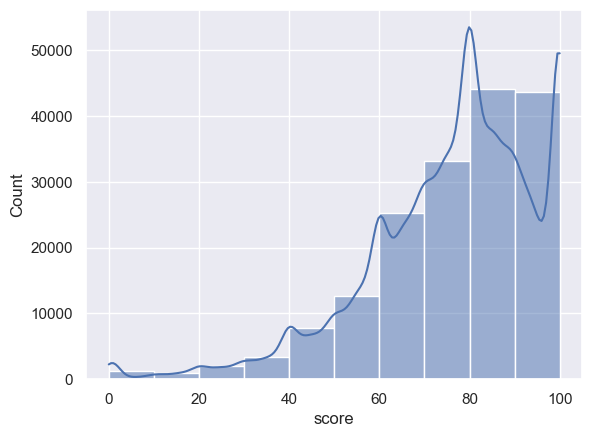

In [7]:
# Check score distribution
sns.histplot(original_data['score'], bins=10, kde=True)

In [8]:
# Check categorical columns
categorical_cols = original_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(col, original_data[col].unique())

### **Synthetic Data Generation**

In [47]:
# Set the start method of the multiprocessing module to 'fork' to avoid an error
multiprocessing.set_start_method('fork', force=True)

# Number of samples to generate
n = 5000

train_data, test_data = train_test_split(original_data, test_size=0.3, random_state=42)
train_data.to_csv("Original_Data/train_data.csv", index=False)
test_data.to_csv("Original_Data/test_data.csv", index=False)

In [10]:
# !! Only use if synthetic data has is not generated yet !!

# Use train_data.csv to fit SDG models and generate synthetic data
# data_path = "Original_Data/train_data.csv"
# arguments = [data_path, str(n), "4"]

# print("Sampling synthpop...")
# result = subprocess.run(['Rscript', 'Data_Generation/synthpop.R',   *arguments], capture_output=True, text=True)

# print("Sampling DataSynthesizer...")
# ds_generate_data(data_path=data_path, num_samples=n, dataset_nr="4")

# sdv_generate_data(data_path=data_path, num_samples=n, dataset_nr="4")

Encode all categorical columns of both original (train+test) data and synthetic data using label encoding

In [48]:

synthpop = pd.read_csv("Synthetic_Data/Dataset_4/synthpop_samples.csv")
ds = pd.read_csv("Synthetic_Data/Dataset_4/ds_samples.csv")
tvae = pd.read_csv("Synthetic_Data/Dataset_4/tvae_samples.csv")
gaussian_copula = pd.read_csv("Synthetic_Data/Dataset_4/gaussian_samples.csv")
copula_gan = pd.read_csv("Synthetic_Data/Dataset_4/copula_gan_samples.csv")
ctgan = pd.read_csv("Synthetic_Data/Dataset_4/ctgan_samples.csv")

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.fit_transform(test_data[col])

    synthpop[col] = le.fit_transform(synthpop[col])
    ds[col] = le.fit_transform(ds[col])
    tvae[col] = le.fit_transform(tvae[col])
    gaussian_copula[col] = le.fit_transform(gaussian_copula[col])
    copula_gan[col] = le.fit_transform(copula_gan[col])
    ctgan[col] = le.fit_transform(ctgan[col])

    label_encoders[col] = le

### **Utility Evaluation**

Prepare utility evaluation

In [49]:
models = [synthpop, ds, tvae, gaussian_copula, copula_gan, ctgan]
model_names = ["synthpop", "ds", "tvae", "gaussian_copula", "copula_gan", "ctgan"]
target_col = "score"

# for model in models:
#     model[target_col] = pd.cut(model[target_col], bins=[0, 50, 80, 100], labels=[0, 1, 2])

# train_data[target_col] = pd.cut(train_data[target_col], bins=[0, 50, 80, 100], labels=[0, 1, 2])
# test_data[target_col] = pd.cut(test_data[target_col], bins=[0, 50, 80, 100], labels=[0, 1, 2])
ds.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,37165.0,581375.0,107.0,0,98.0
1,15596.0,591435.0,70.0,0,97.0
2,34624.0,399738.0,9.0,0,63.0
3,14706.0,506810.0,54.0,0,43.0
4,24079.0,430390.0,37.0,0,93.0


In [34]:
# See if any of the datasets contain nan values
for i, model in enumerate(models):
    print(model_names[i])
    print(model.isnull().sum().sum())
    print("at index: ", model[model.isnull().any(axis=1)].index)


synthpop
6
at index:  Index([888, 1703, 3309, 4468, 4503, 4539], dtype='int64')
ds
3
at index:  Index([969, 2327, 3510], dtype='int64')
tvae
5
at index:  Index([330, 1226, 2044, 2452, 2529], dtype='int64')
gaussian_copula
0
at index:  Index([], dtype='int64')
copula_gan
7
at index:  Index([473, 2309, 2548, 2694, 3518, 4387, 4589], dtype='int64')
ctgan
4
at index:  Index([687, 3135, 4071, 4117], dtype='int64')


In [54]:
for i, model in enumerate(models):
    print(model_names[i])
    print((model[target_col]==0).sum())

synthpop
0       False
1       False
2       False
3       False
4       False
        ...  
4995    False
4996    False
4997    False
4998    False
4999    False
Name: score, Length: 5000, dtype: bool


AttributeError: 'NoneType' object has no attribute 'sum'

Run random forest classifier for utility evaluation

In [31]:
rf_results = {}
rf_df = pd.read_csv("Evaluation_Results/RF_Results.csv")
rows = []
for i, model in enumerate(models):
    rf_results[model_names[i]] = run_utility_eval(train_data, test_data, model, target_col, "random_forest")
    acc_diff = rf_results[model_names[i]]["acc_diff"]
    f1_diff = rf_results[model_names[i]]["f1_diff"]
    roc_auc_diff = rf_results[model_names[i]]["roc_auc_diff"]
    rows.append([4, model_names[i], acc_diff, f1_diff, roc_auc_diff])
rows = pd.DataFrame(rows, columns=rf_df.columns)
rf_df = pd.concat([rf_df, rows])
rf_df.to_csv("Evaluation_Results/RF_Results.csv", index=False)
rf_df.head()

ValueError: Input y contains NaN.

Run logistic regression for utility evaluation

In [14]:
lr_results = {}
lr_df = pd.read_csv("Evaluation_Results/LR_Results.csv")
rows = []

for i, model in enumerate(models):
    lr_results[model_names[i]] = run_utility_eval(train_data, test_data, model, target_col, "logistic_regression")

    acc_diff = lr_results[model_names[i]]["acc_diff"]
    f1_diff = lr_results[model_names[i]]["f1_diff"]
    roc_auc_diff = lr_results[model_names[i]]["roc_auc_diff"]

    rows.append([4, model_names[i], acc_diff, f1_diff, roc_auc_diff])

rows = pd.DataFrame(rows, columns=lr_df.columns)
lr_df = pd.concat([lr_df, rows])
lr_df.to_csv("Evaluation_Results/LR_Results.csv", index=False)
lr_df.tail(7)

ValueError: Number of classes in y_true not equal to the number of columns in 'y_score'

Run multilayer perceptron (MLP)

In [ ]:
mlp_results = {}
mlp_df = pd.read_csv("Evaluation_Results/MLP_Results.csv")
rows = []

for i, model in enumerate(models):
    mlp_results[model_names[i]] = run_utility_eval(train_data, test_data, model, target_col, "multilayer_perceptron")

    acc_diff = mlp_results[model_names[i]]["acc_diff"]
    f1_diff = mlp_results[model_names[i]]["f1_diff"]
    roc_auc_diff = mlp_results[model_names[i]]["roc_auc_diff"]

    rows.append([4, model_names[i], acc_diff, f1_diff, roc_auc_diff])

rows = pd.DataFrame(rows, columns=mlp_df.columns)
mlp_df = pd.concat([mlp_df, rows])
mlp_df.to_csv("Evaluation_Results/MLP_Results.csv", index=False)
mlp_df.tail(7)

/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

synthpop
{'acc_original': 0.10727565454057576, 'f1_original': 0.020818182626679393, 'acc_synth': 0.1036531605780657, 'f1_synth': 0.02218401644529241, 'acc_diff': 0.003622493962510062, 'f1_diff': -0.001365833818613018} 

ds
{'acc_original': 0.10727565454057576, 'f1_original': 0.020818182626679393, 'acc_synth': 0.022271629547284087, 'f1_synth': 0.002052127386849384, 'acc_diff': 0.08500402499329168, 'f1_diff': 0.01876605523983001} 

tvae
{'acc_original': 0.10727565454057576, 'f1_original': 0.020818182626679393, 'acc_synth': 0.01820830298616169, 'f1_synth': 0.0013092164518646613, 'acc_diff': 0.08906735155441407, 'f1_diff': 0.01950896617481473} 

gaussian_copula
{'acc_original': 0.10727565454057576, 'f1_original': 0.020818182626679393, 'acc_synth': 0.005251657913903477, 'f1_synth': 0.0012189273334575158, 'acc_diff': 0.10202399662667229, 'f1_diff': 0.019599255293221877} 

copula_gan
{'acc_original': 0.10727565454057576, 'f1_original': 0.020818182626679393, 'acc_synth': 0.00866331889446851, '

/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

### **Resemblance**

Run multiple resemblance metrics: Difference in pairwise correlation, Jensen-Shannon divergence, Wasserstein distance

- Correlation distance diff : lower values are better
- JSD in [0,1] range: lower values are better
- WD: lower values are better


**Difference in pairwise correlation:**

In [15]:
corr_diff_df = pd.read_csv("Evaluation_Results/corr_diff.csv")
corr_diff_results = {}
rows = []

for i, model in enumerate(models):
    corr_diff_results[model_names[i]] = pairwise_correlation_diff(train_data, model)
    rows.append([4,model_names[i], corr_diff_results[model_names[i]]])

rows = pd.DataFrame(rows, columns=corr_diff_df.columns)
corr_diff_df = pd.concat([corr_diff_df, rows])
corr_diff_df.to_csv("Evaluation_Results/corr_diff.csv", index=False)
corr_diff_df.tail(7)

,Dataset,Model,Pairwise Corr Diff
29,5,ctgan,0.081352
0,4,synthpop,0.006577
1,4,ds,0.056456
2,4,tvae,0.034444
3,4,gaussian_copula,0.027260
4,4,copula_gan,0.093150
5,4,ctgan,0.098660


**Jensen-Shannon Divergence**

In [16]:
jsd_df = pd.read_csv("Evaluation_Results/jsd.csv")
jsd_results = {}
rows = []

for i, model in enumerate(models):
    jsd_results[model_names[i]] = jsd(train_data, model)
    rows.append([4,model_names[i], jsd_results[model_names[i]]])

rows = pd.DataFrame(rows, columns=jsd_df.columns)
jsd_df = pd.concat([jsd_df, rows])
jsd_df.to_csv("Evaluation_Results/jsd.csv", index=False)
jsd_df.tail(7)

,Dataset,Model,JSD Diff
29,5,ctgan,0.012078
0,4,synthpop,0.081678
1,4,ds,0.299084
2,4,tvae,0.170130
3,4,gaussian_copula,0.306706
4,4,copula_gan,0.250960
5,4,ctgan,0.235035


**Wasserstein Distance**

In [17]:
wd_df = pd.read_csv("Evaluation_Results/wd.csv")
wd_results = {}
rows = []

for i, model in enumerate(models):
    wd_results[model_names[i]] = wd(train_data, model)
    rows.append([4,model_names[i], wd_results[model_names[i]]])

rows = pd.DataFrame(rows, columns=wd_df.columns)
wd_df = pd.concat([wd_df, rows])
wd_df.to_csv("Evaluation_Results/wd.csv", index=False)
wd_df.tail(7)

,Dataset,Model,WD Diff
29,5,ctgan,0.045989
0,4,synthpop,0.000402
1,4,ds,0.003279
2,4,tvae,0.003226
3,4,gaussian_copula,0.001977
4,4,copula_gan,0.075103
5,4,ctgan,0.074660


### **Privacy**

**Distance to closest record (DCR)**

In [18]:
dcr_df = pd.read_csv("Evaluation_Results/dcr.csv")
dcr_results = {}
rows = []

for i, model in enumerate(models):
    dcr_results[model_names[i]] = dcr(train_data, model, model_names[i], dataset_nr=4, save_hist=True)
    rows.append([4,model_names[i], dcr_results[model_names[i]]])

rows = pd.DataFrame(rows, columns=dcr_df.columns)
dcr_df = pd.concat([dcr_df, rows])
dcr_df.to_csv("Evaluation_Results/dcr.csv", index=False)
dcr_df.tail(7)

,Dataset,Model,Avg DCR
23,5,ctgan,0.308441
0,4,synthpop,0.159140
1,4,ds,0.165169
2,4,tvae,0.150923
3,4,gaussian_copula,0.164948
4,4,copula_gan,0.238651
5,4,ctgan,0.236270


<Figure size 640x480 with 0 Axes>

**Nearest Neighbor distance ratio (NNDR)**

In [19]:
nndr_df = pd.read_csv("Evaluation_Results/nndr.csv")
nndr_results = {}
rows = []

for i, model in enumerate(models):
    nndr_results[model_names[i]] = nndr(train_data, model)
    rows.append([4,model_names[i], nndr_results[model_names[i]]])

rows = pd.DataFrame(rows, columns=nndr_df.columns)
nndr_df = pd.concat([nndr_df, rows])
nndr_df.to_csv("Evaluation_Results/nndr.csv", index=False)
nndr_df.tail(7) 

,Dataset,Model,Avg NNDR
23,5,ctgan,0.911334
0,4,synthpop,0.440841
1,4,ds,0.867543
2,4,tvae,0.737831
3,4,gaussian_copula,0.892483
4,4,copula_gan,0.734791
5,4,ctgan,0.757055


**Membership Inference Attack (MIA)**

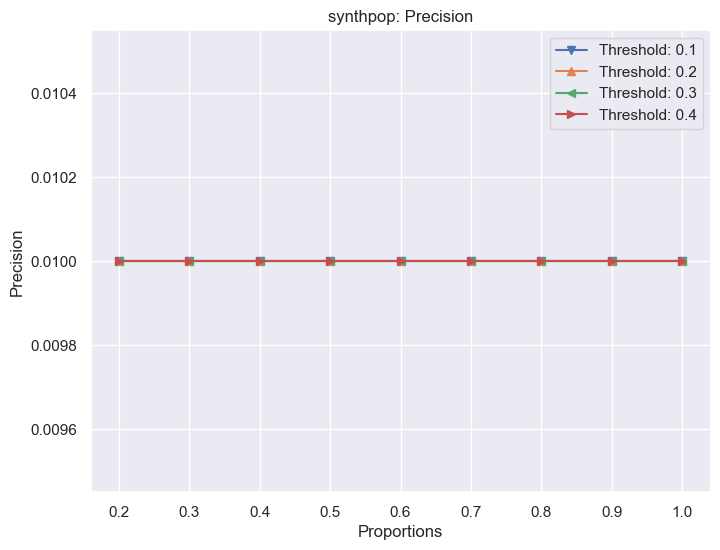

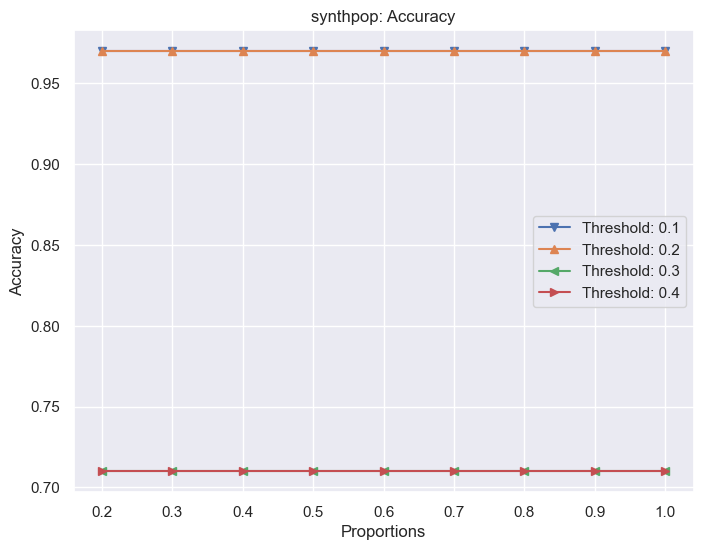

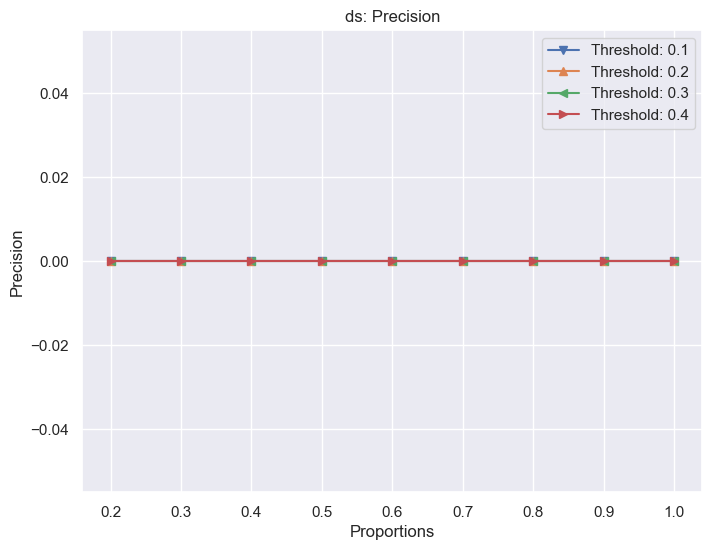

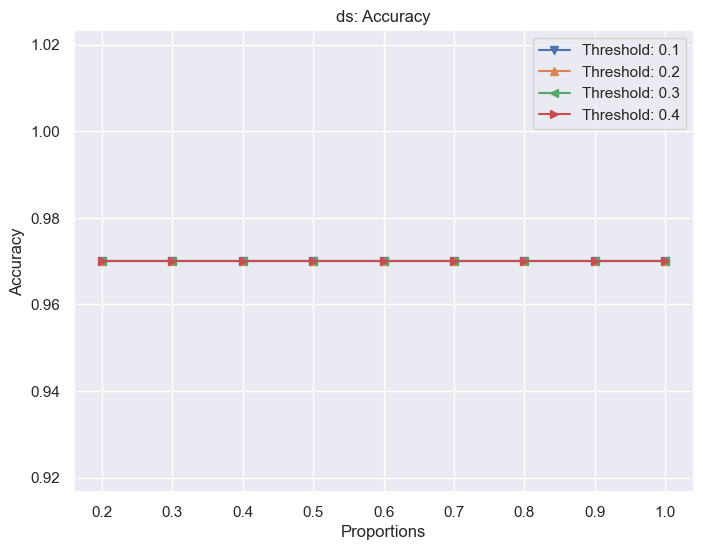

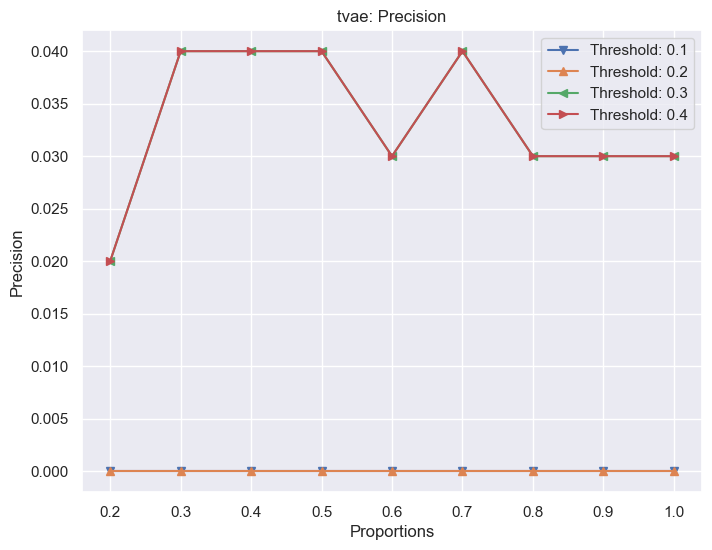

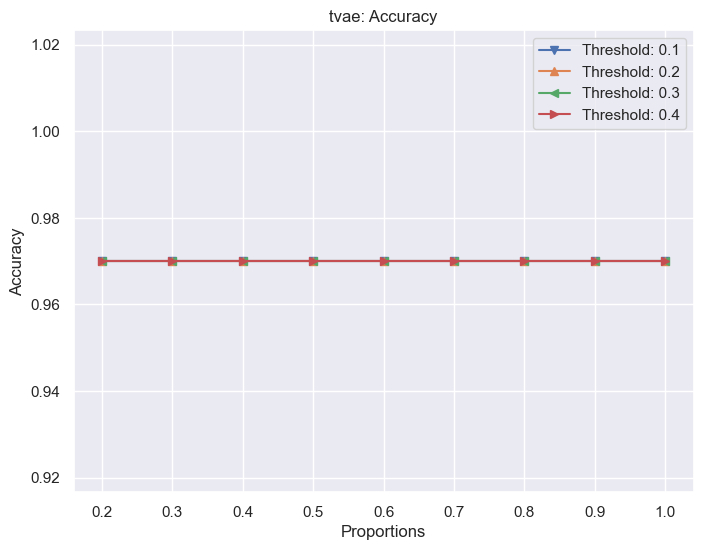

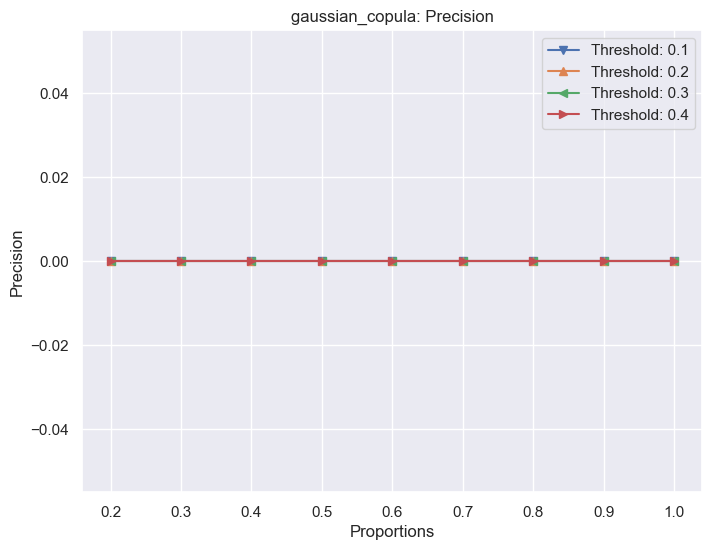

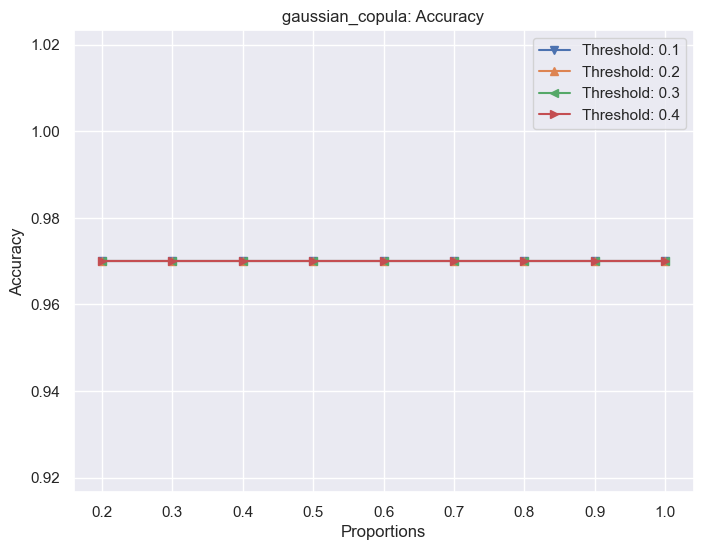

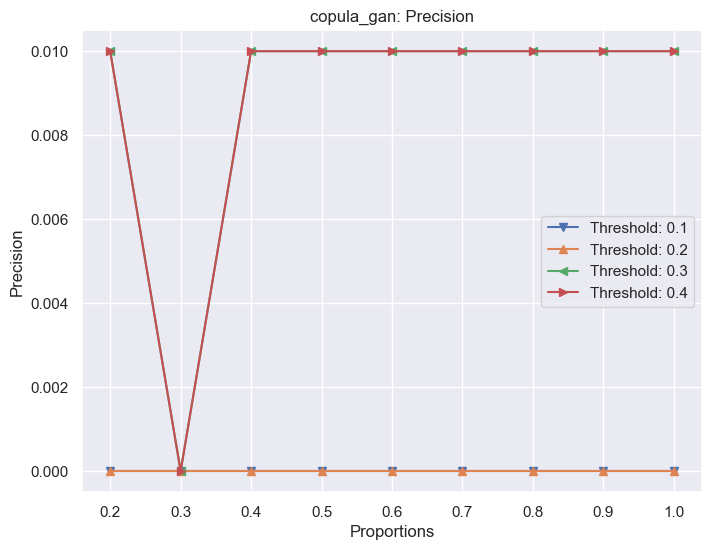

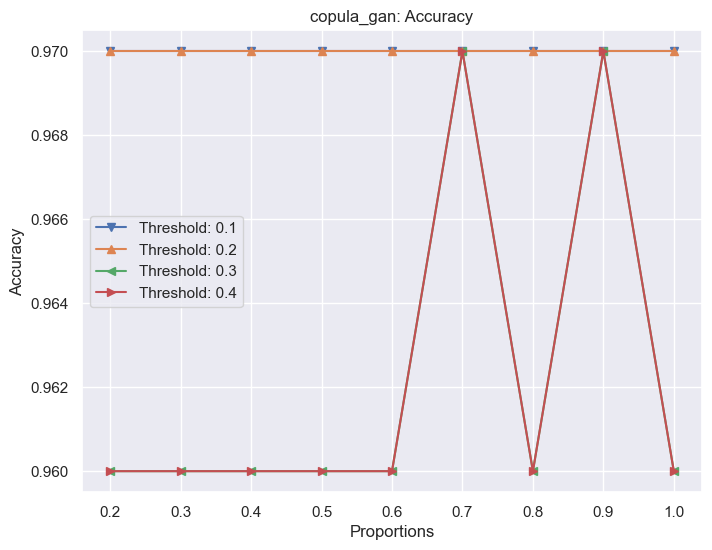

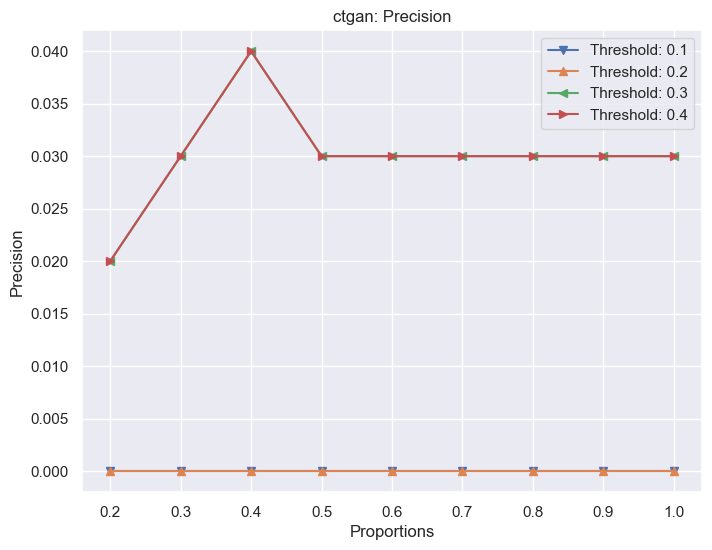

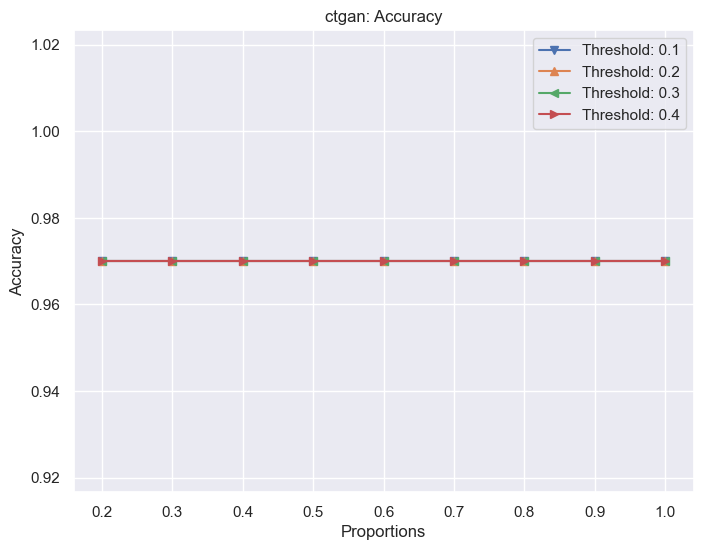

In [20]:
mia_results = {}
for i, model in enumerate(models):
    mia_results[model_names[i]] = mia(train_data, model, model_names[i], dataset_nr=4, save_plts=True)
